In [1]:
# 필요한 라이브러리 임포트
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from torchvision.datasets import VOCSegmentation
from PIL import Image
import os
import numpy as np
from lovasz_losses import lovasz_softmax

In [2]:
class ToTensorWithoutNormalization:
    def __call__(self, img):
        # PIL 이미지를 NumPy 배열로 변환
        img_np = np.array(img)
        # NumPy 배열을 torch tensor로 변환 (정규화 없이)
        img_tensor = torch.from_numpy(img_np)
        return img_tensor.float()

In [3]:
# Transformations for data
transform_1 = T.Compose([
    T.Resize((255, 255)),
    T.ToTensor(),
])

transform_2 = T.Compose([
    T.Resize((255, 255)),
    ToTensorWithoutNormalization(),
])

# Load Pascal VOC dataset
train_dataset = VOCSegmentation(root='.', year='2012', image_set='train', download=True, transform=transform_1, target_transform=transform_2)
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
dataloader = train_loader

Using downloaded and verified file: ./VOCtrainval_11-May-2012.tar
Extracting ./VOCtrainval_11-May-2012.tar to .


In [4]:
# Transformations for data
transform_1 = T.Compose([
    T.Resize((255, 255)),
    T.ToTensor(),
])

transform_2 = T.Compose([
    T.Resize((255, 255)),
    ToTensorWithoutNormalization(),
])

# Load Pascal VOC dataset
valid_dataset = VOCSegmentation(root='.', year='2012', image_set='val', download=True, transform=transform_1, target_transform=transform_2)
val_loader = DataLoader(valid_dataset, batch_size=8, shuffle=True)

Using downloaded and verified file: ./VOCtrainval_11-May-2012.tar
Extracting ./VOCtrainval_11-May-2012.tar to .


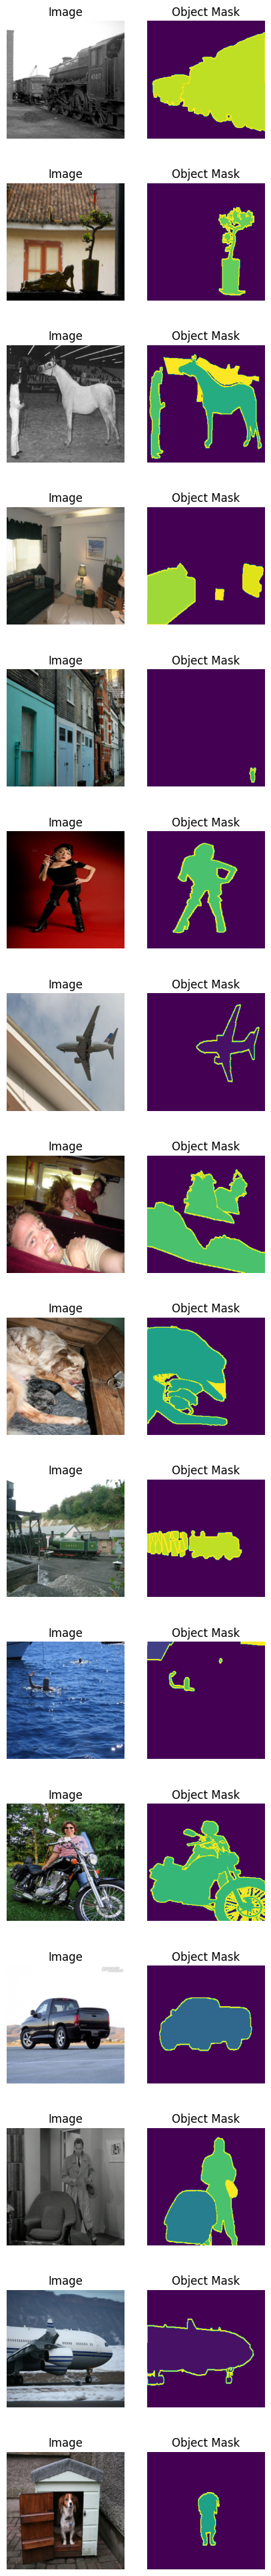

In [19]:
# 이미지와 객체 마스크 시각화
def show_images_and_masks(dataloader):
    batch = next(iter(dataloader))  # 배치에서 첫 번째 데이터를 가져옴
    images, masks = batch

    fig, axes = plt.subplots(len(images), 2, figsize=(5,50))
    for i in range(len(images)):
        # 이미지
        img = images[i].permute(1, 2, 0).numpy()
        axes[i, 0].imshow(img)
        axes[i, 0].set_title('Image')
        axes[i, 0].axis('off')

        # 마스크
        mask = torch.clamp(masks[i],max=21).numpy()
        axes[i, 1].imshow(mask)  # 마스크 이미지 표시
        axes[i, 1].set_title('Object Mask')
        axes[i, 1].axis('off')

    plt.show()
show_images_and_masks(dataloader)

In [6]:
class UNet(nn.Module):
    def __init__(self):
        super(UNet, self).__init__()
        
        def CBR(in_channels, out_channels):
            return nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
                nn.BatchNorm2d(out_channels),
                nn.ReLU(inplace=True)
            )
        
        # Encoder
        self.enc1 = nn.Sequential(CBR(3, 64), CBR(64, 64))
        self.enc2 = nn.Sequential(CBR(64, 128), CBR(128, 128))
        self.enc3 = nn.Sequential(CBR(128, 256), CBR(256, 256))
        self.enc4 = nn.Sequential(CBR(256, 512), CBR(512, 512))

        # Bottleneck
        self.bottleneck = nn.Sequential(CBR(512, 1024), CBR(1024, 1024))
        
        # Decoder
        self.dec4 = nn.Sequential(CBR(1024 + 512, 512), CBR(512, 512))
        self.dec3 = nn.Sequential(CBR(512 + 256, 256), CBR(256, 256))
        self.dec2 = nn.Sequential(CBR(256 + 128, 128), CBR(128, 128))
        self.dec1 = nn.Sequential(CBR(128 + 64, 64), CBR(64, 64))
        
        # Final output layer
        self.final = nn.Conv2d(64, 22, kernel_size=1)

        # Max pooling
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        # Upsampling
        self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)

    def forward(self, x):
        # Encoder
        e1 = self.enc1(x)
        e2 = self.enc2(self.pool(e1))
        e3 = self.enc3(self.pool(e2))
        e4 = self.enc4(self.pool(e3))
        
        # Bottleneck
        b = self.bottleneck(self.pool(e4))
        
        # Decoder
        d4 = self._crop_and_concat(self.up(b), e4)
        d4 = self.dec4(d4)

        d3 = self._crop_and_concat(self.up(d4), e3)
        d3 = self.dec3(d3)

        d2 = self._crop_and_concat(self.up(d3), e2)
        d2 = self.dec2(d2)

        d1 = self._crop_and_concat(self.up(d2), e1)
        d1 = self.dec1(d1)
        
        # Final output
        out = self.final(d1)
        return out

    # 크기를 맞추기 위한 헬퍼 함수
    def _crop_and_concat(self, upsampled, bypass):
        """
        업샘플링된 텐서(upsampled)와 스킵 연결 텐서(bypass)의 크기를 맞춰 결합합니다.
        """
        diff_y = bypass.size(2) - upsampled.size(2)
        diff_x = bypass.size(3) - upsampled.size(3)

        # 크기 차이만큼 crop하여 텐서 크기를 맞춤
        upsampled = torch.nn.functional.pad(upsampled, [diff_x // 2, diff_x - diff_x // 2,
                                                        diff_y // 2, diff_y - diff_y // 2])
        return torch.cat([upsampled, bypass], dim=1)


In [7]:
# 손실함수설정
def lovasz_loss(pred, target):
    pred = F.softmax(pred, dim=1)
    return lovasz_softmax(pred, target)

In [9]:
device = 'cuda:3'
model = UNet().to(device)
#model.load_state_dict(torch.load('model_state_dict_v_losaz.pt')) to load the saved model
optimizer = optim.AdamW(model.parameters(), lr=1e-4)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=3, factor=0.5)

/tmp/ipykernel_2678408/2541074835.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('model_state_dict_v_losaz.pt'))


In [24]:
# 손실 함수 및 옵티마이저 정의
num_epochs= 50

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    for images, masks in dataloader:
        images = images.to(device)
        masks = torch.clamp(masks, max=21).type(torch.long).to(device)
        # Forward pass
        outputs = model(images)
        loss = lovasz_loss(outputs, masks)

        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
    
    scheduler.step(running_loss)

    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for images, masks in val_loader:
            images = images.to(device)
            masks = torch.clamp(masks, max=21).type(torch.long).to(device)

            # Forward pass
            outputs = model(images)
            valloss = lovasz_loss(outputs, masks)

            val_loss += valloss.item()
    

    print(f'Epoch [{epoch+1}/{num_epochs}], Train loss: {running_loss/len(dataloader):4f},  Val loss: {val_loss/len(val_loader):4f}')
    



Epoch [1/50], Train loss: 0.697077,  Val loss: 0.748101
Epoch [2/50], Train loss: 0.697395,  Val loss: 0.748964
Epoch [3/50], Train loss: 0.698696,  Val loss: 0.756309
Epoch [4/50], Train loss: 0.696176,  Val loss: 0.747650
Epoch [5/50], Train loss: 0.692530,  Val loss: 0.743123
Epoch [6/50], Train loss: 0.687376,  Val loss: 0.742437
Epoch [7/50], Train loss: 0.683875,  Val loss: 0.743160
Epoch [8/50], Train loss: 0.680022,  Val loss: 0.749050
Epoch [9/50], Train loss: 0.688246,  Val loss: 0.745592
Epoch [10/50], Train loss: 0.681346,  Val loss: 0.748244
Epoch [11/50], Train loss: 0.677638,  Val loss: 0.743484
Epoch [12/50], Train loss: 0.677211,  Val loss: 0.760068
Epoch [13/50], Train loss: 0.679545,  Val loss: 0.742116
Epoch [14/50], Train loss: 0.669876,  Val loss: 0.746051
Epoch [15/50], Train loss: 0.667299,  Val loss: 0.741942
Epoch [16/50], Train loss: 0.665495,  Val loss: 0.744911
Epoch [17/50], Train loss: 0.662378,  Val loss: 0.733723
Epoch [18/50], Train loss: 0.660188,  Va

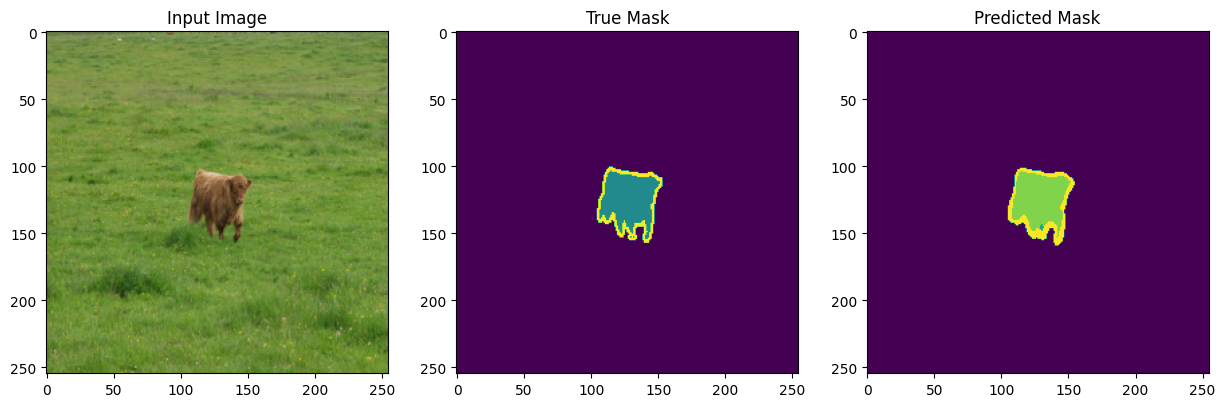

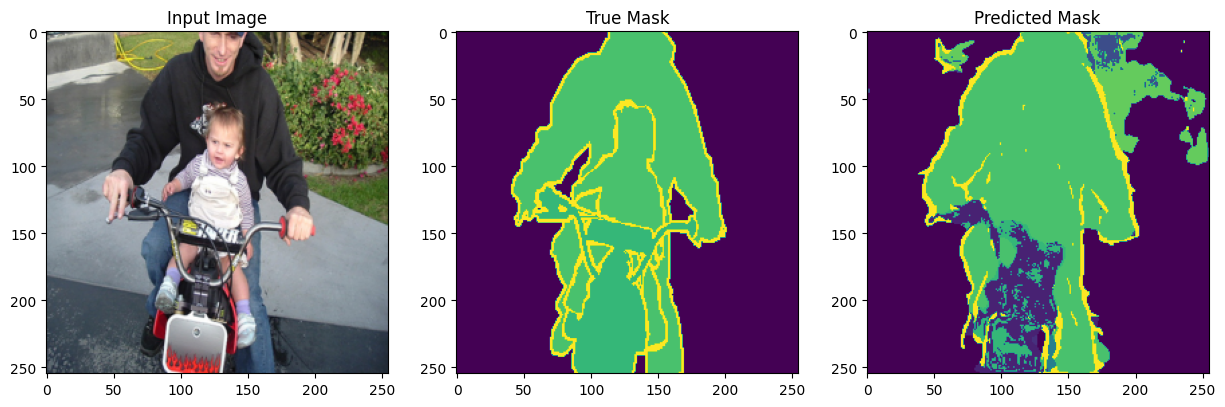

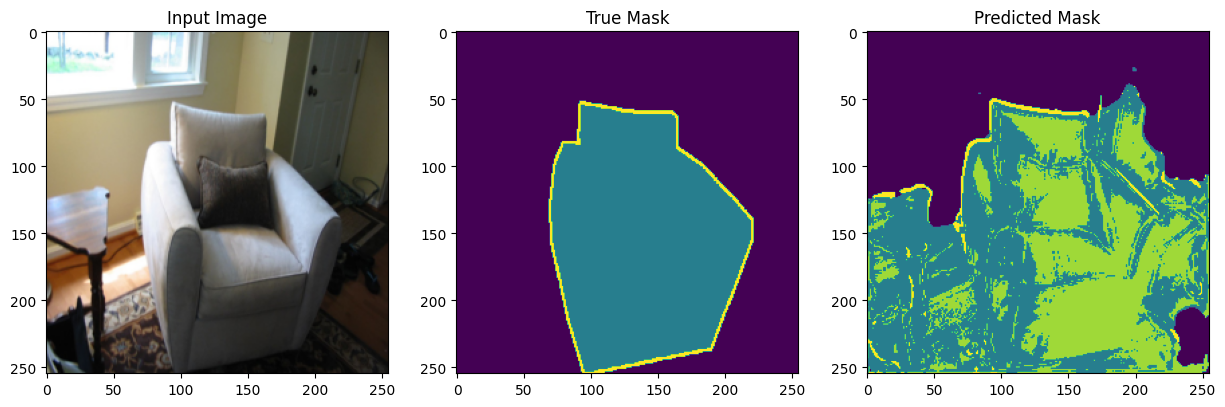

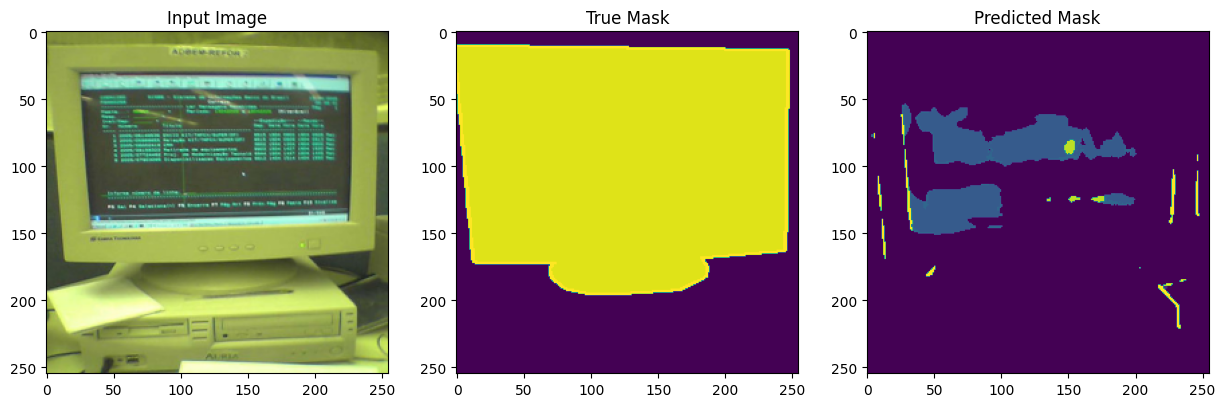

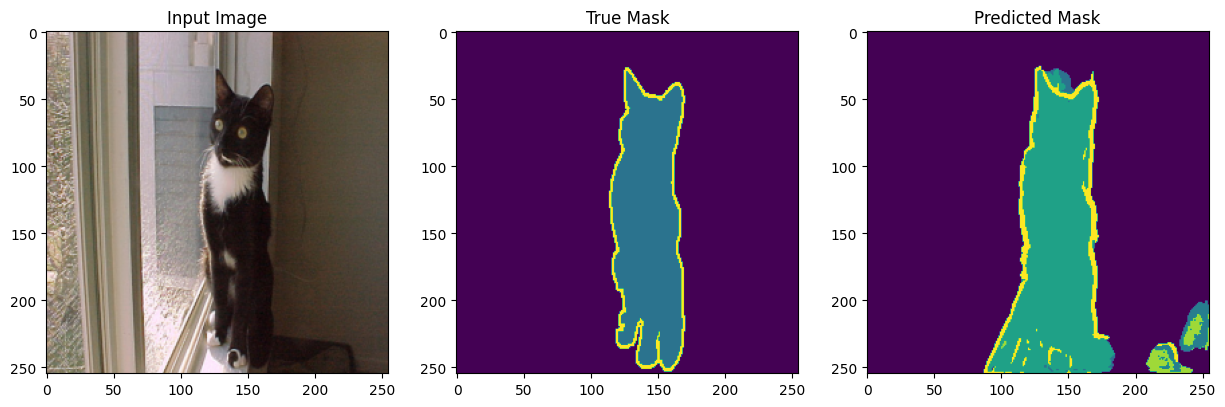

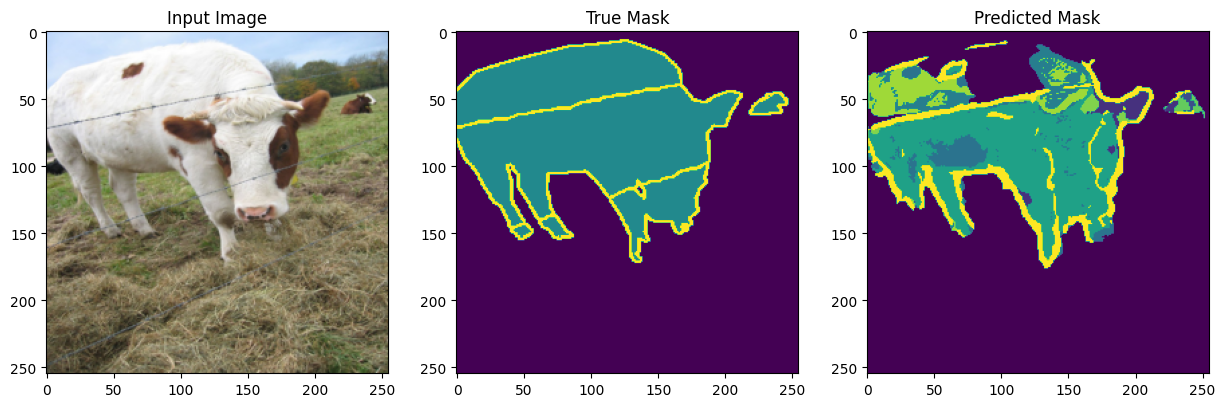

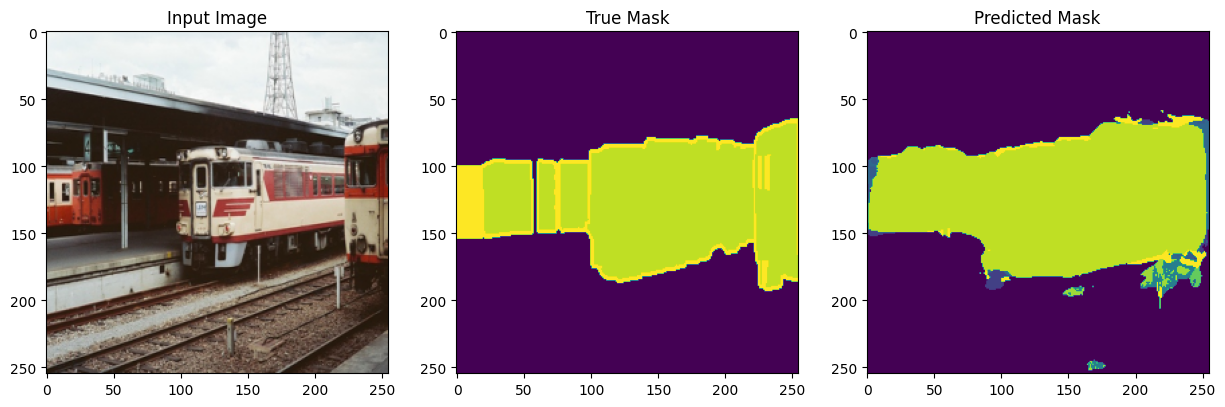

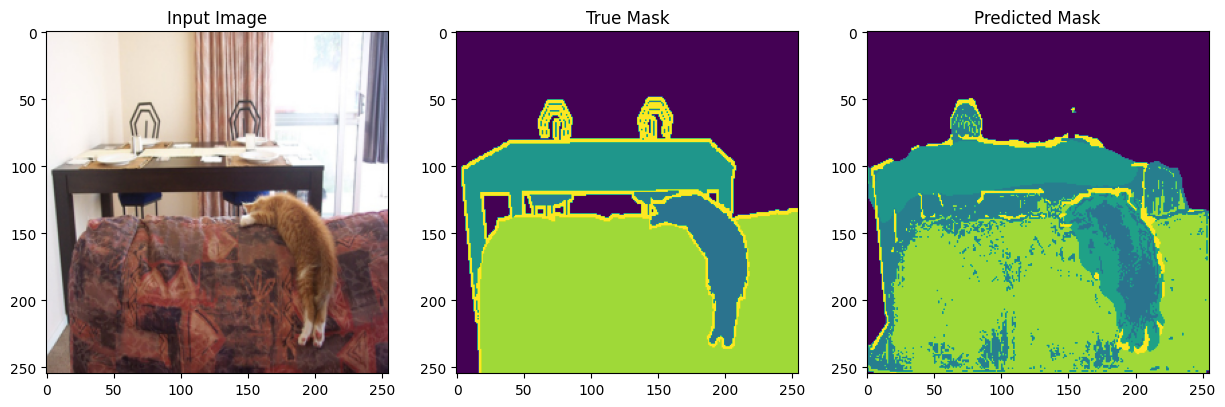

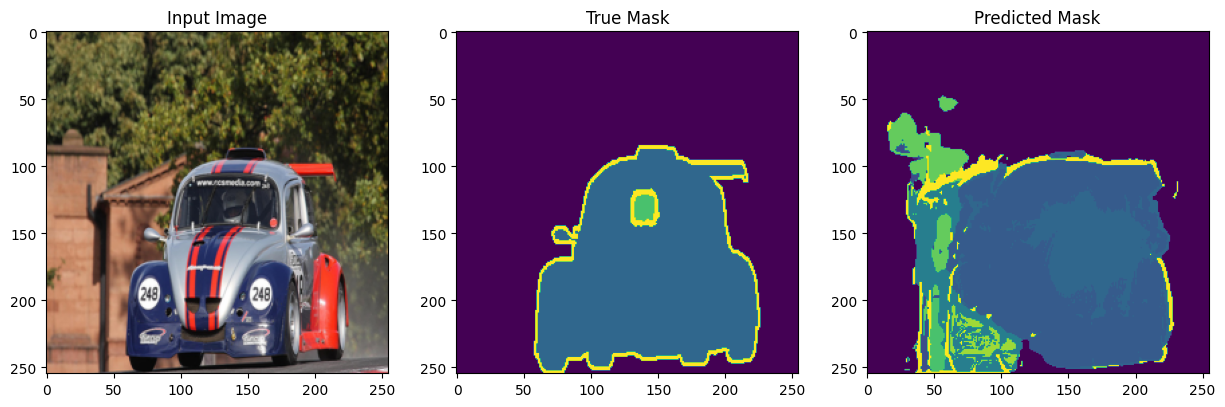

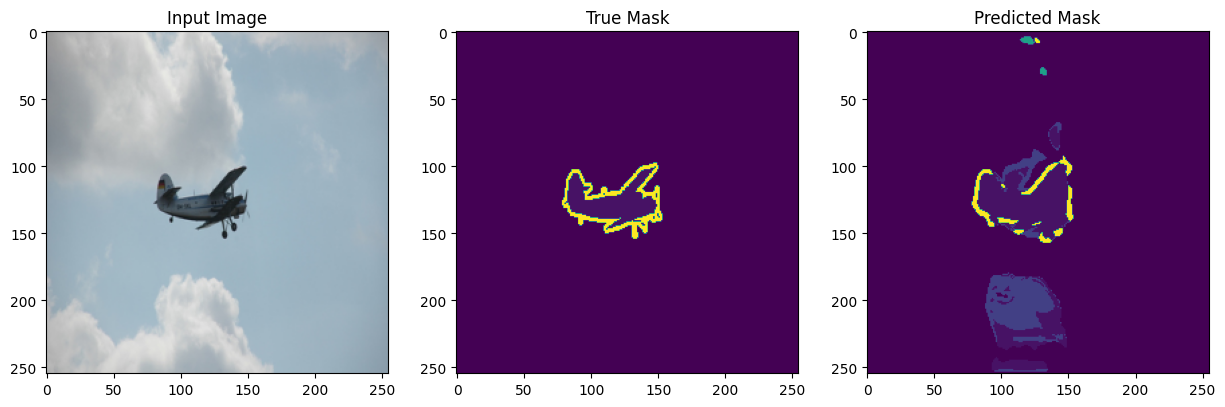

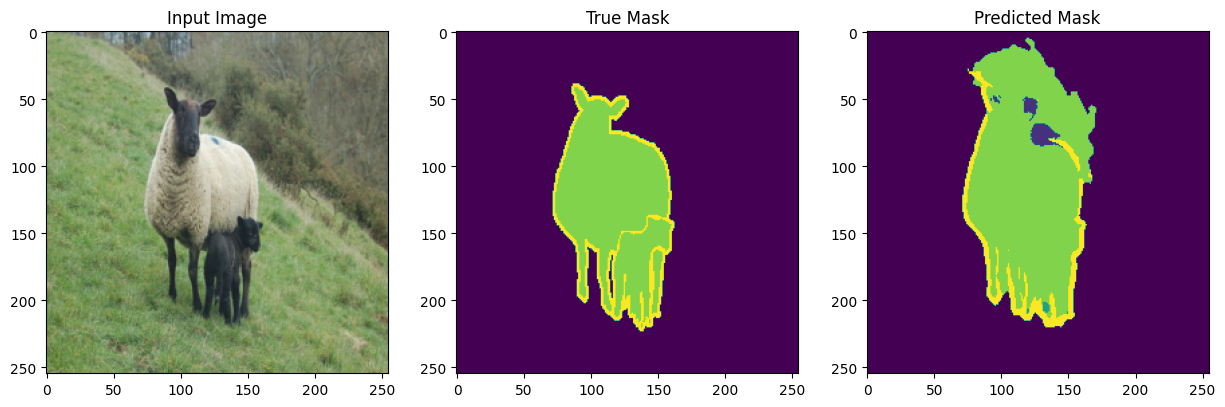

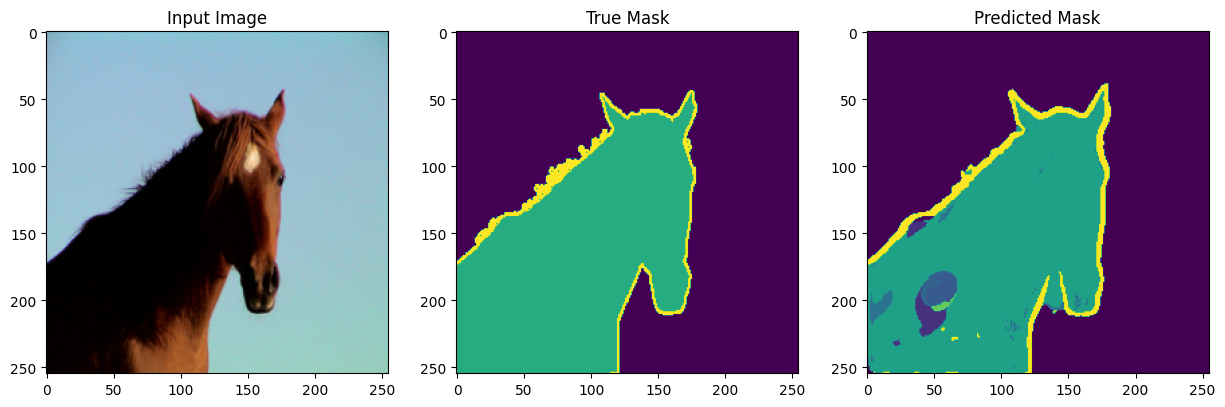

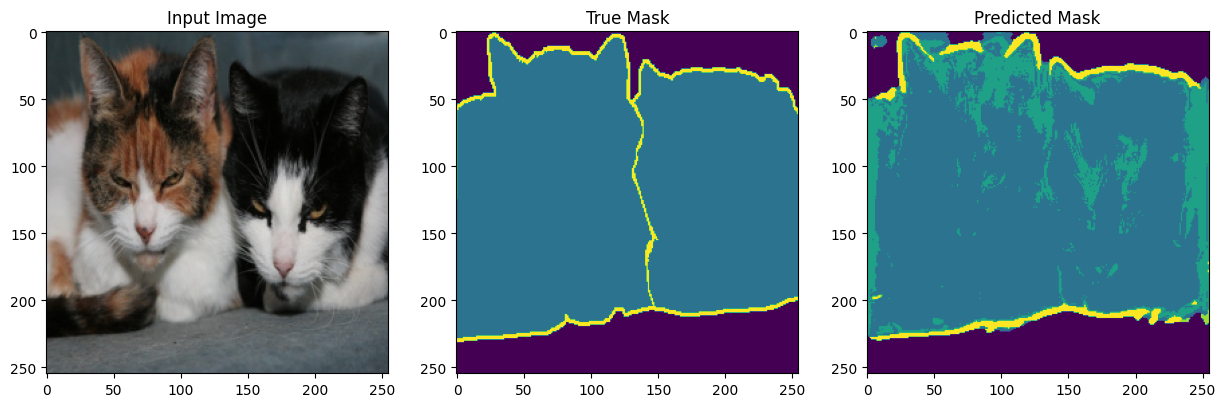

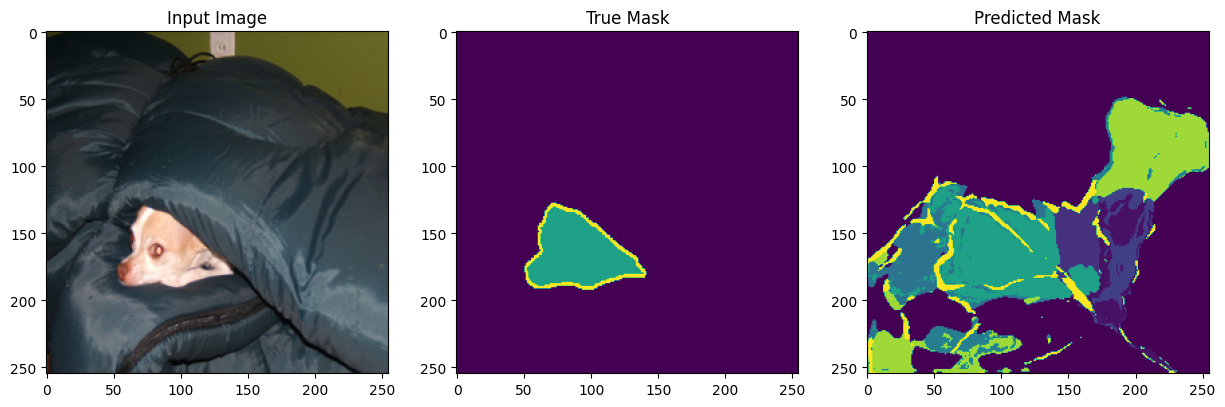

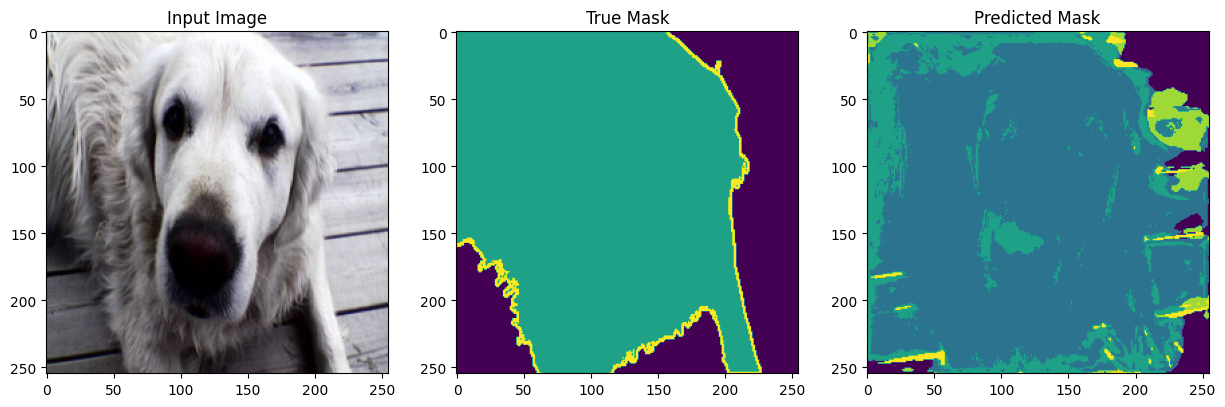

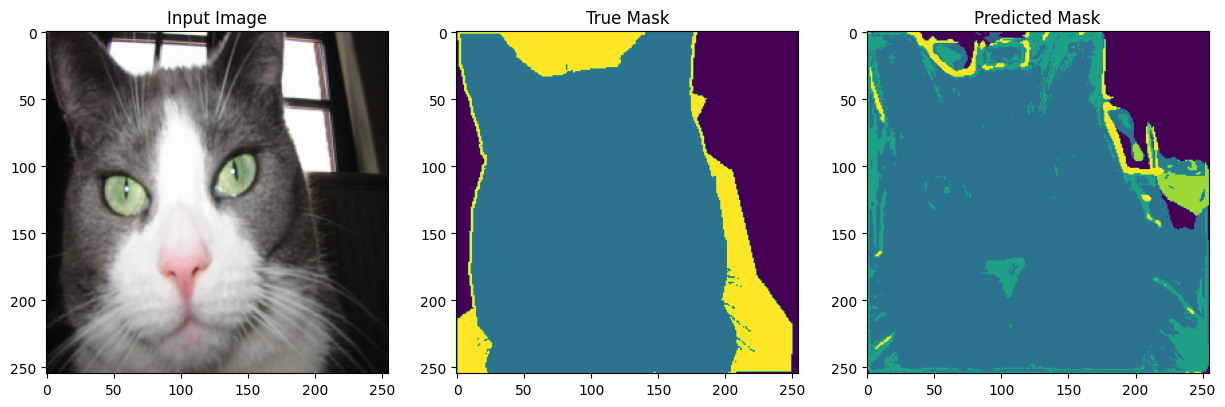

In [20]:
# 모델 평가 및 예측 결과 시각화 함수

val_dataloader = val_loader

model.eval()  # 모델을 평가 모드로 전환
model = model.to(device)

with torch.no_grad():  # 학습이 아닌 평가이므로 no_grad() 사용
    for idx, (images, masks) in enumerate(train_loader):
        if idx >= 1:  # 5개의 예측 결과만 시각화
            break

        images = images.to(device)
        masks = masks.to(device)
        masks = torch.clamp(masks, max=21)  # 실제 마스크의 차원 추가

        # 모델에 이미지를 입력하여 예측
        outputs = model(images)
        preds = torch.argmax(outputs, dim=1)

        # CPU로 변환 및 numpy로 변환
        images = images.cpu().numpy()
        masks = masks.cpu().numpy()
        preds = preds.cpu().numpy()

        # 시각화를 위해 이미지 및 마스크 데이터 처리
        for i in range(images.shape[0]):  # 배치 내 각 이미지에 대해
            image = np.transpose(images[i], (1, 2, 0))  # (C, H, W) -> (H, W, C)
            mask = masks[i]  # (1, H, W) -> (H, W)
            pred = preds[i]  # (1, H, W) -> (H, W)

            # 예측 결과와 실제 마스크를 시각화
            fig, ax = plt.subplots(1, 3, figsize=(15, 5))
            ax[0].imshow(image)
            ax[0].set_title('Input Image')
            ax[1].imshow(mask)
            ax[1].set_title('True Mask')
            ax[2].imshow(pred)
            ax[2].set_title('Predicted Mask')
            plt.show()

In [12]:
# 모델 저장
torch.save(model.state_dict(), 'model_state_dict.pt')